## Extraction of features to be used by the somatic validation

In [2]:
import json
from pathlib import Path

In [33]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
import seaborn as sns


%matplotlib inline
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (12,12)

In [3]:
from extract_features import translate_legacy_targets, get_files_metadata, extract_efeatures

In [4]:
traces_dir = Path("..") / "feature_extraction" / "input-traces"

cell_ids = (
    "C060109A1-SR-C1",
    "C060109A2-SR-C1",
    "C060109A3-SR-C1",
    "C070109A4-C1",
    "C080501A5-SR-C1",
    "C080501B2-SR-C1",
)

with open("experiments.json", "r") as f:
    experiments = json.load(f)

#### The protocols to be used in extraction

IDRest and IDthresh protocols will only be used in the computation of the rheobase.

In [5]:
experiments.keys()

dict_keys(['IDRest', 'IDthresh', 'IDhyperpol', 'sAHP', 'APThreshold'])

In [6]:
experiments["sAHP"]

{'location': 'soma.v',
 'tolerances': [20.0],
 'targets': [150, 170, 200, 220, 250, 270, 300, 350],
 'efeatures': ['Spikecount',
  'AP_amplitude',
  'inv_first_ISI',
  'AP_height',
  'inv_time_to_first_spike',
  'decay_time_constant_after_stim',
  'AHP_depth_abs',
  'sag_amplitude',
  'sag_ratio1',
  'steady_state_voltage',
  'minimum_voltage',
  'steady_state_voltage_stimend']}

### Translating the experiments into a format that bluepyefe2 understands

In [7]:
targets = translate_legacy_targets(experiments)
files_metadata = get_files_metadata(traces_dir, cell_ids, experiments)

Cells used 6/6


### Running the extraction

Enable the plot flag for more detailed plots to be written in the etype directory.

In [8]:
etype = "L5PC"
protocols_rheobase = ["IDthresh", "IDRest"]
extract_efeatures(
    etype, files_metadata, targets, protocols_rheobase, plot=False, per_cell=True
)

It seems that the i_file and v_file are reversed for file: ../feature_extraction/input-traces/C080501A5-SR-C1/exp_IDthresh_ch1_989.ibw
It seems that the i_file and v_file are reversed for file: ../feature_extraction/input-traces/C080501A5-SR-C1/exp_IDthresh_ch1_963.ibw
It seems that the i_file and v_file are reversed for file: ../feature_extraction/input-traces/C080501A5-SR-C1/exp_IDthresh_ch1_988.ibw
It seems that the i_file and v_file are reversed for file: ../feature_extraction/input-traces/C080501A5-SR-C1/exp_IDthresh_ch1_978.ibw
It seems that the i_file and v_file are reversed for file: ../feature_extraction/input-traces/C080501A5-SR-C1/exp_IDthresh_ch1_961.ibw
It seems that the i_file and v_file are reversed for file: ../feature_extraction/input-traces/C080501A5-SR-C1/exp_IDthresh_ch1_979.ibw
It seems that the i_file and v_file are reversed for file: ../feature_extraction/input-traces/C080501A5-SR-C1/exp_IDthresh_ch1_958.ibw
It seems that the i_file and v_file are reversed for fi

extracting features for per cell...


Number of values < threshold_nvalue_save for efeature sag_amplitude stimulus IDhyperpol_300. The efeature will be ignored
Number of values < threshold_nvalue_save for efeature sag_ratio1 stimulus IDhyperpol_300. The efeature will be ignored
Number of values < threshold_nvalue_save for efeature minimum_voltage stimulus IDhyperpol_300. The efeature will be ignored
Number of values < threshold_nvalue_save for efeature steady_state_voltage_stimend stimulus IDhyperpol_300. The efeature will be ignored
No efeatures for stimulus IDhyperpol_300. The protocol will not be created.
Number of values < threshold_nvalue_save for efeature Spikecount stimulus IDhyperpol_350. The efeature will be ignored
Number of values < threshold_nvalue_save for efeature AP_amplitude stimulus IDhyperpol_350. The efeature will be ignored
Number of values < threshold_nvalue_save for efeature ISI_values stimulus IDhyperpol_350. The efeature will be ignored
Number of values < threshold_nvalue_save for efeature AP_height

In [9]:
5

5

## Features extracted from a group of cells

In this section we will look at the features extracted from a group of cells having the (cADpyr) e-type.

In [10]:
with open(Path(etype) / "features.json", "r") as features_file:
    etype_features = json.load(features_file)

In [12]:
etype_features.keys()

dict_keys(['IDthresh_120', 'IDhyperpol_150', 'IDhyperpol_170', 'IDhyperpol_200', 'IDhyperpol_220', 'IDhyperpol_250', 'IDhyperpol_270', 'sAHP_150', 'sAHP_170', 'sAHP_200', 'sAHP_220', 'sAHP_250', 'sAHP_270', 'sAHP_300', 'sAHP_350', 'APThreshold_300', 'APThreshold_330'])

We are going to use the following functions in plotting the features.

In [26]:
def features_df(features_config: dict, protocol: str) -> pd.DataFrame:
    """Returns the dataframe containing features for the given protocol."""
    df = pd.DataFrame(features_config[protocol]["soma"])
    df["mean"] = df["val"].apply(lambda x : x[0])
    df["variance"] = df["val"].apply(lambda x : x[1])
    df = df.drop(['val', "efeature_name"], axis=1)
    return df

def feature_plot(df: pd.DataFrame, protocol: str) -> None:
    """Plots the features of a dataframe containing features extracted from a protocol."""
    fig, axs = plt.subplots()
    axs.errorbar(y = range(len(df)), x = df["mean"], xerr=df['variance'], fmt='o', color='midnightblue',
                ecolor='steelblue', elinewidth=2.5, capsize=6)
    axs.set_yticks(range(len(df)))
    axs.set_yticklabels(df["feature"])
    axs.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axs.set_xlabel("feature values")
    plt.title(f"Features extracted on {protocol} protocol responses")
    plt.show()

# Features extracted from the sAHP_250 protocol

The below table shows the features extracted from the recordings done using sAHP_250 protocol.

n stands for the number of traces used in computing the feature.

In [31]:
sahp_250 = "sAHP_250"
etype_sahp_df = features_df(etype_features, sahp_250)
etype_sahp_df.head(10)

,feature,n,efel_settings,mean,variance
0,Spikecount,5,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",5.400000,1.019804
1,AP_amplitude,5,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",74.787983,7.394354
2,inv_first_ISI,5,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",62.086144,15.392788
3,AP_height,5,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",19.571869,4.943031
4,inv_time_to_first_spike,5,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",146.431510,23.021836
5,decay_time_constant_after_stim,5,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",3.546628,0.791888
6,AHP_depth_abs,5,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",-59.396771,3.815092
7,steady_state_voltage,5,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",-77.053410,2.341820
8,minimum_voltage,5,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",-86.000000,2.555015
9,steady_state_voltage_stimend,5,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",-71.906108,2.479452


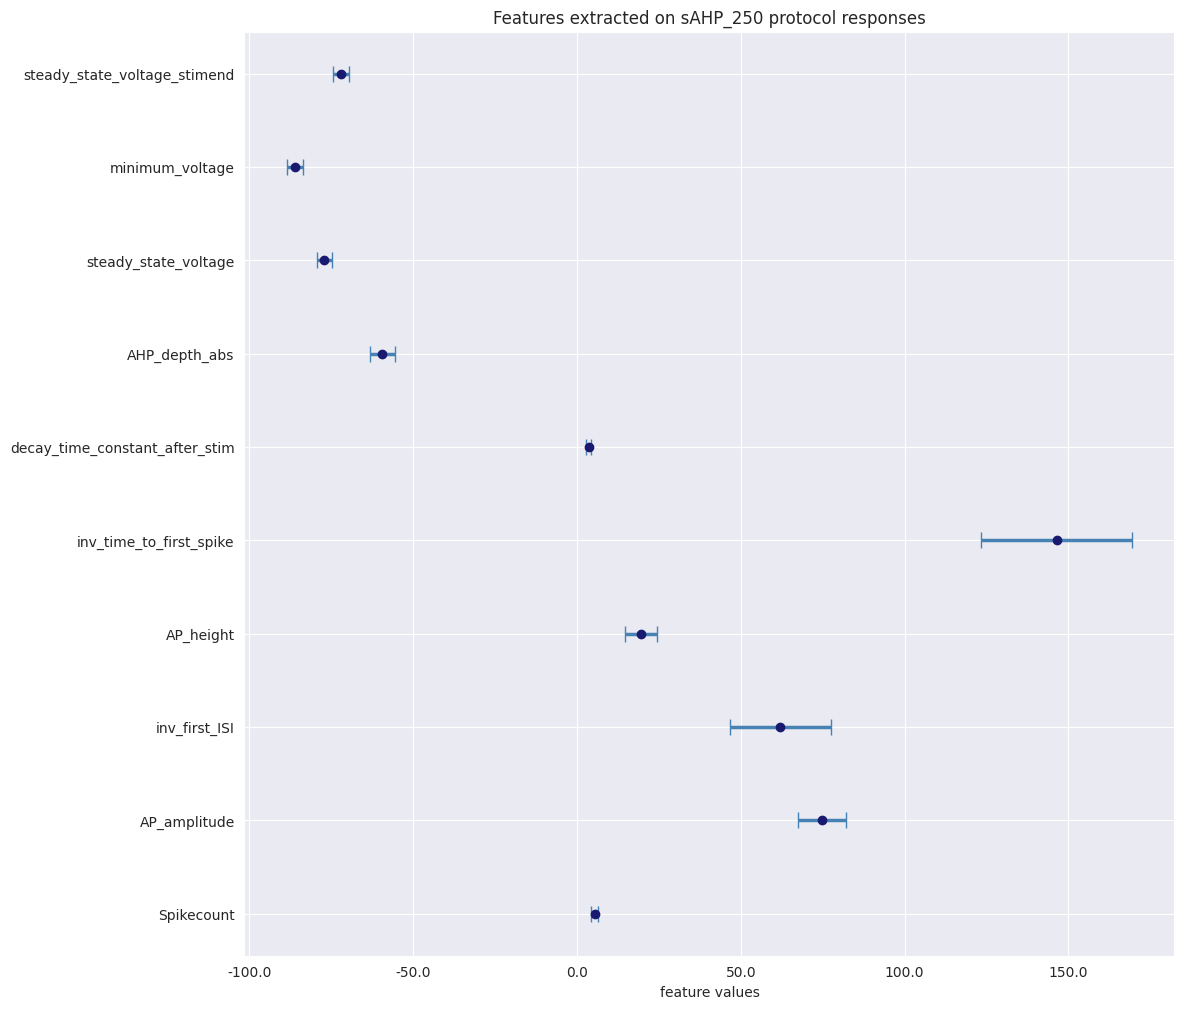

In [34]:
feature_plot(etype_sahp_df, sahp_250)

# Features extracted from the APThreshold_300 protocol

In [35]:
apthreshold_300 = "APThreshold_300"
apthreshold_df = features_df(etype_features, apthreshold_300)
apthreshold_df.head(10)

,feature,n,efel_settings,mean,variance
0,Spikecount,12,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",14.166667,0.687184
1,AP_amplitude,12,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",72.549796,8.843906
2,inv_time_to_first_spike,12,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",1.251683,0.053098
3,ISI_log_slope,12,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",-0.342702,0.016009
4,ISI_CV,12,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",0.283915,0.015063
5,AP1_amp,12,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",75.807292,8.253128
6,APlast_amp,12,"{'Threshold': -30.0, 'interp_step': 0.1, 'stri...",69.822395,9.849927


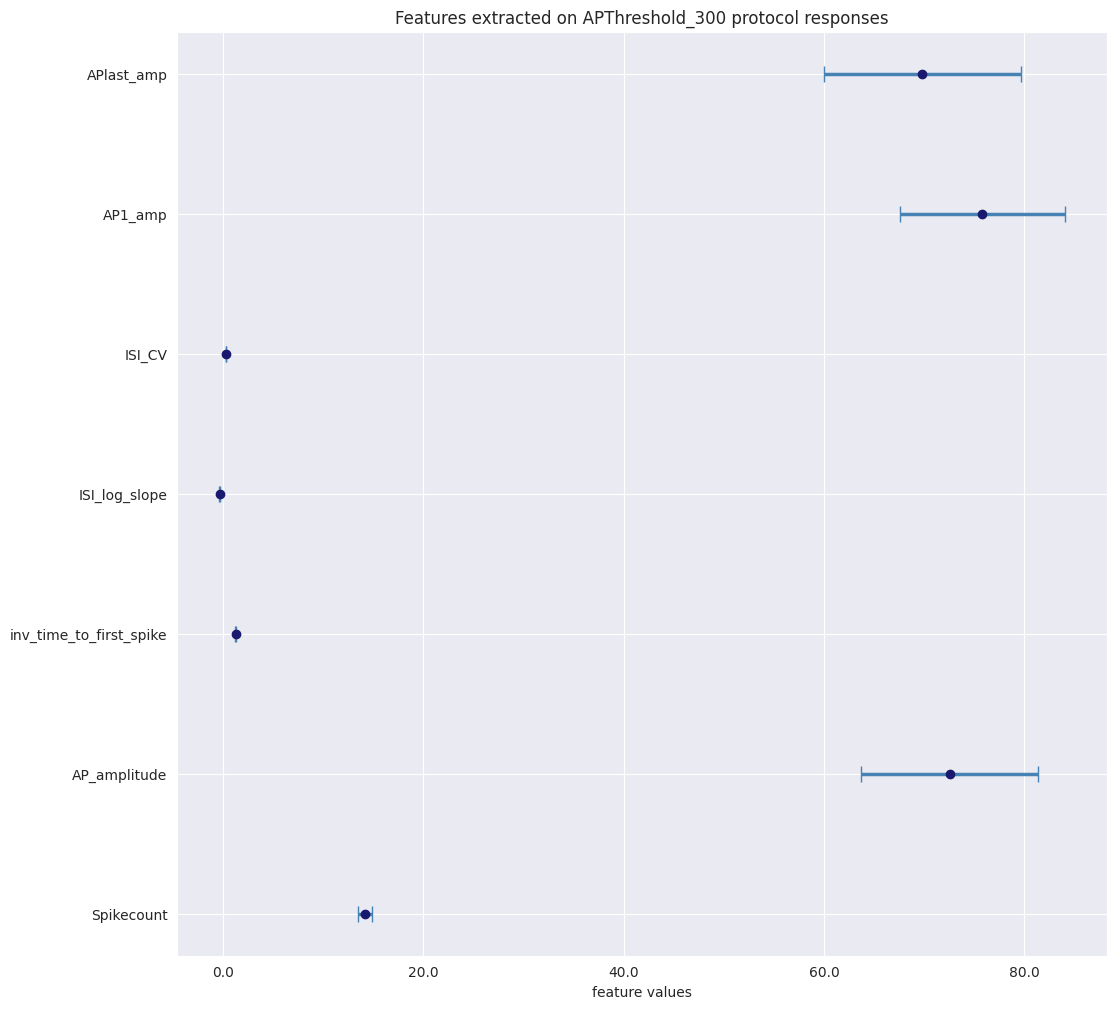

In [36]:
feature_plot(apthreshold_df, apthreshold_300)